#Lecture 4 - A Generative Adversarial Network example

**VERY IMPORTANT**: Begin developing this network in CPU mode so Colab doesn't kick you out when you need to train.

**Dependencies**

In [ ]:
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 55.6 MB/s eta 0:00:00


Load your drive using this (if necessary):

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Set up dependencies of the notebook

In [ ]:
import datetime
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms

import pytorch_lightning as pl
import torchmetrics
from pytorch_lightning import seed_everything
from pytorch_lightning.utilities.combined_loader import CombinedLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image


# A CycleGAN - From scratch!

In this **notebook**, we are implementing a **CycleGAN** to perform img2img tasks given a label. This notebook is meant to be a self-contained exercise on Generative Adversarial Networks, the exercise is open-ended.

Link to the article: [arxiv.org/abs/1703.10593](https://arxiv.org/abs/1703.10593)

This exercise requires:

* Define data loading
* Define the Generator AB and Generator BA
* Define the Discriminator
* Join the Gab, Gba & Da and Db to form the CycleGAN
* Define the training loop of the CycleGAN
* Train the CycleGAN

Architecture example:

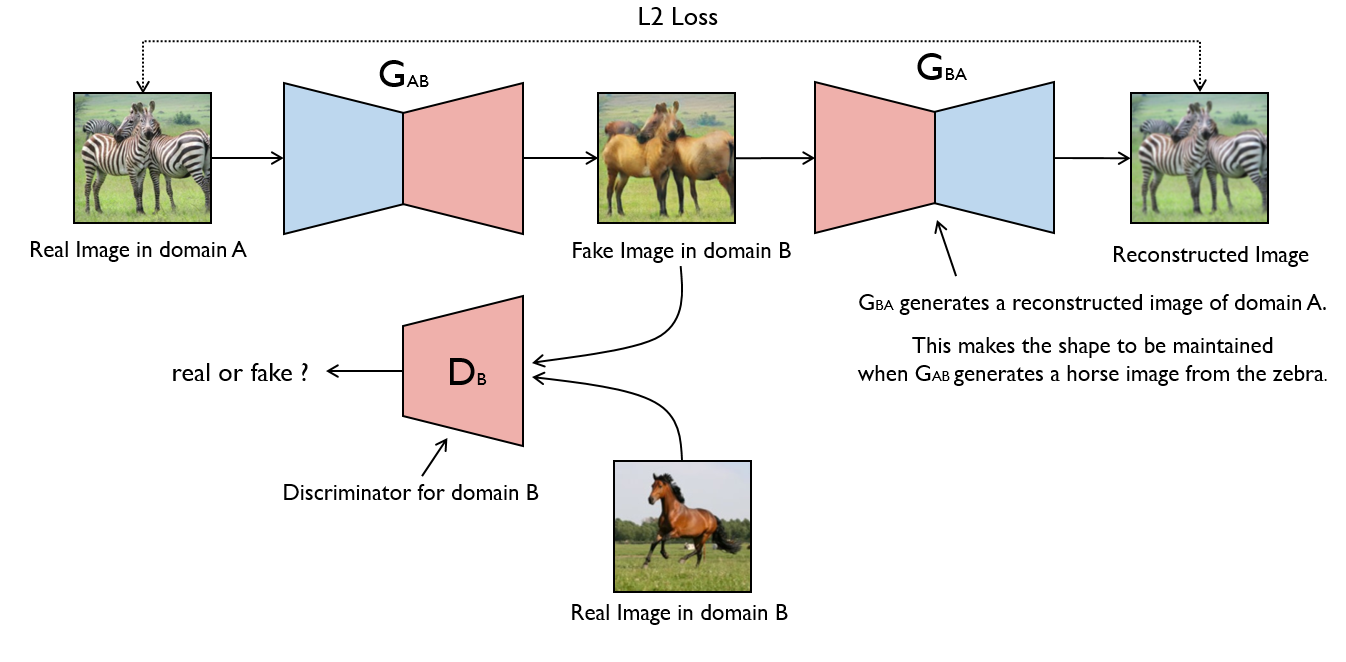

The architecture will be explained furhter into the exercise but the summary is the following. The CycleGAN has 3 components, a generator that turns class A to class B $G_{AB}$, another generator to perform the inverse operation $G_{BA}$ and a discriminator for each type of image $D_A$ and $D_B$.

To learn we need several loss terms, namely: A discriminator loss, a reconstruction loss and the usual generator adversarial loss.

## Data Loading
The data loading requires downloading the data from kaggle: [balraj98/horse2zebra-dataset](https://www.kaggle.com/datasets/balraj98/horse2zebra-dataset)

This dataset contains horses and zebras, which we will try to transform one into the other.

First, unzip the contents here, in the notebook.

In [ ]:
!unzip archive.zip

Archive:  archive.zip
  inflating: metadata.csv            
  inflating: testA/n02381460_1000.jpg  
  inflating: testA/n02381460_1010.jpg  
  inflating: testA/n02381460_1030.jpg  
  inflating: testA/n02381460_1090.jpg  
  inflating: testA/n02381460_1100.jpg  
  inflating: testA/n02381460_1110.jpg  
  inflating: testA/n02381460_1120.jpg  
  inflating: testA/n02381460_1160.jpg  
  inflating: testA/n02381460_120.jpg  
  inflating: testA/n02381460_1210.jpg  
  inflating: testA/n02381460_1260.jpg  
  inflating: testA/n02381460_1300.jpg  
  inflating: testA/n02381460_1350.jpg  
  inflating: testA/n02381460_1360.jpg  
  inflating: testA/n02381460_140.jpg  
  inflating: testA/n02381460_1420.jpg  
  inflating: testA/n02381460_1540.jpg  
  inflating: testA/n02381460_1620.jpg  
  inflating: testA/n02381460_1630.jpg  
  inflating: testA/n02381460_1660.jpg  
  inflating: testA/n02381460_1690.jpg  
  inflating: testA/n02381460_1740.jpg  
  inflating: testA/n02381460_1750.jpg  
  inflating: testA/n02

In [ ]:
DATA_PATH = 'metadata.csv'
SEED = 42
seed_everything(seed=SEED) # Set seed for reproducibility,

Seed set to 42


42

Load the dataset and check the head.

In [ ]:
zh_df = pd.read_csv(DATA_PATH) # Drop the class,
zh_df.head()

,image_id,domain,split,image_path
0,n02381460_1000,B (Zebra),test,testB/n02381460_1000.jpg
1,n02381460_1001,A (Horse),train,trainA/n02381460_1001.jpg
2,n02381460_1002,A (Horse),train,trainA/n02381460_1002.jpg
3,n02381460_1003,A (Horse),train,trainA/n02381460_1003.jpg
4,n02381460_1006,A (Horse),train,trainA/n02381460_1006.jpg


In [ ]:
image_path = ''

# Function to check if an image file exists
def image_exists(image_name):
    image_location = os.path.join(image_path, image_name)
    return os.path.exists(image_location)

# Filter the DataFrame to keep only rows where the image exists
zh_df = zh_df[zh_df['image_path'].apply(image_exists)]

In [ ]:
zh_df.domain.value_counts()

domain
B (Zebra)    1354
A (Horse)    1067
Name: count, dtype: int64

First, to train we need a pair of images. We need a dataset that returns images from the dataset.

Take into account:
* `image_path` contains the path to an image of the specified type in `domain`.
* `split` indicates the split of the dataframe

So, the class `ImageDataset` is going to return either Horses or zebras, but be careful, there are more Zebras (1474) than Horses (1187), be wary of these pairings!

The `split` should be taken care of during the Module declaration, otherwise you would mix train and test easily.

In [ ]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, metadata, domain, img_size=256, split='train', root=''):
        self.df = metadata[(metadata.domain == domain) &
                           (metadata.split == split)]
        self.root = root
        self.split = split
        self.train_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(img_size),
            transforms.RandomCrop(img_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ])
        self.val_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(img_size),
            transforms.CenterCrop(img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        data_file = self.df.iloc[index].image_path
        data_file = os.path.join(self.root , data_file)
        np_img = np.array(Image.open(data_file))

        if len(np_img.shape) == 2:
            np_img = np.stack((np_img,)*3, axis=-1)

        if self.split == 'train':
            img_tensor = self.train_transform(np_img)
        else:
            img_tensor = self.val_transform(np_img)

        return img_tensor

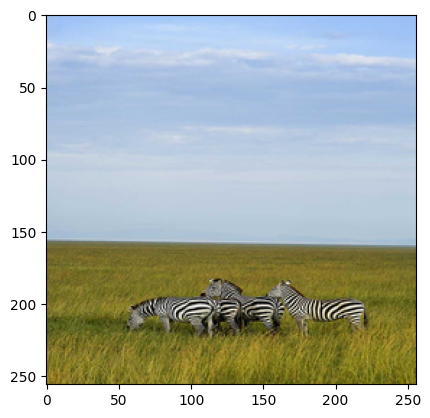

In [ ]:
zebras_train = ImageDataset(zh_df, 'B (Zebra)', split='train')
horses_train = ImageDataset(zh_df, 'A (Horse)', split='train')
zebras_val = ImageDataset(zh_df, 'B (Zebra)', split='test')

#Example zebra
zebra_image = zebras_val[0].permute(1, 2, 0) * 0.5 + 0.5
plt.imshow(zebra_image)
plt.show()

Finally, declare the `pl.LightningDataModule` with both datasets!

Use `CombinedLoader` to easily interleave datasets.

In [ ]:
class ZHModule(pl.LightningDataModule):
    def __init__(self, df, batch_size=16, img_size=256):
        super().__init__()
        self.individual_batch_size = batch_size // 2
        self.img_size = img_size
        self.df = df

    def setup(self, stage=None):
        # We can't perform numerical evaluations! Only train + val
        self.zebras_train = ImageDataset(self.df, 'B (Zebra)', split='train', img_size=self.img_size)
        self.horses_train = ImageDataset(self.df, 'A (Horse)', split='train', img_size=self.img_size)
        self.zebras_test = ImageDataset(self.df, 'B (Zebra)', split='test', img_size=self.img_size)

    def collate_fn(self, batch):
        features = torch.stack(batch, axis=0)  # [batch_size, input_size]
        return features

    def train_dataloader(self):
        loader_zebras = torch.utils.data.DataLoader(self.zebras_train,
                                                    batch_size=self.individual_batch_size,
                                                    shuffle=True,
                                                    collate_fn=self.collate_fn)
        loader_horses = torch.utils.data.DataLoader(self.horses_train,
                                                    batch_size=self.individual_batch_size,
                                                    shuffle=True,
                                                    collate_fn=self.collate_fn)

        return CombinedLoader({'zebra': loader_zebras,
                               'horse': loader_horses}, 'max_size_cycle')

    def val_dataloader(self):
        loader_zebras = torch.utils.data.DataLoader(self.zebras_test,
                                                    batch_size=self.individual_batch_size,
                                                    shuffle=False,
                                                    collate_fn=self.collate_fn)

        return CombinedLoader({'zebra': loader_zebras,}, 'max_size_cycle')

## GAN

Implement the Generators and discriminators. You can use the design from previous exercises for the discriminator, but you will ned something else for the generator. This generator must receive an image and return another image with the exact same shape (3 colors, 256x256).

You're free to describe any network of your liking, but rememeber, if the input has shape [b, h, w, c], then, the result should be exactly the same shape!

We recommend using a UNET style network for the Generators, as they are really good interpreting images.

### General generator recommendations
- Make the network with few parameters, 10~20Mill parameters should do the trick.
- Usually we downsample to make the network parameter and time efficient, try downscaling and upscaling the image.
- Personal note: I achieved fair results with just 3 downsampling layers and 3 upsampling layers.

In [ ]:
class GenericBlock(nn.Module):
    def __init__(self, in_channels, out_channels, mode='conv', is_first=False):
        super().__init__()
        kernel_size = 7 if is_first else 3
        padding = 3 if is_first else 1

        if mode == 'conv':
            beginning_layer = nn.Conv2d(in_channels, out_channels,
                                        kernel_size=kernel_size,
                                        stride=1,
                                        padding=padding)
        if mode == 'upsample':
            beginning_layer = nn.ConvTranspose2d(in_channels, out_channels,
                                                 kernel_size=kernel_size,
                                                 padding=1,
                                                 stride=2,
                                                 output_padding=padding)
        if mode == 'downsample':
            beginning_layer = nn.Conv2d(in_channels, out_channels,
                                        kernel_size=kernel_size,
                                        stride=2,
                                        padding=padding)

        self.mode = mode
        self.block = nn.Sequential(
            beginning_layer,
            nn.InstanceNorm2d(out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, padding=0),
            nn.InstanceNorm2d(out_channels)
        )

    def forward(self, x):
        if self.mode == 'conv':
            return F.gelu(x + self.block(x))
        else:
            return self.block(x)

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_size=3, output_size=3, downsample_steps=5, residual_blocks=6, init_width=32):
        super(Generator, self).__init__()

        # Declaring downsample layers
        encoders = []
        for i in range(downsample_steps):
            in_channels = int(input_size if i == 0 else init_width * 2 ** (i - 1))
            out_channels = int(init_width * 2 ** i)
            encoders.append(GenericBlock(in_channels, out_channels, mode='downsample', is_first=(i==0)))
        self.encoders = nn.ModuleList(encoders)

        # Declaring resnet reasoning
        resnet = []
        for i in range(residual_blocks):
            resnet.append(GenericBlock(init_width * 2 ** (downsample_steps - 1),
                                       init_width * 2 ** (downsample_steps - 1), mode='conv'))
        self.resnet = nn.Sequential(*resnet)

        # Declaring upsample layers
        decoders = []
        for i in range(downsample_steps):
            in_channels = int(init_width * 2 ** (downsample_steps - 1 - i)) * 2
            out_channels = int(init_width * 2 ** (downsample_steps - 2 - i))
            decoders.append(GenericBlock(in_channels, out_channels, mode='upsample'))
        self.decoders = nn.ModuleList(decoders)


        self.conv_out = nn.Sequential(
            nn.Conv2d(out_channels, output_size, kernel_size=7, padding=3, stride=1),
            nn.Tanh()
        )


    def forward(self, x):
        # Encoder forward pass
        encoder_outs = [x]
        for encoder in self.encoders:
            encoder_outs.append(encoder(encoder_outs[-1]))

        # Resnet forward pass
        resnet_out = self.resnet(encoder_outs[-1])

        # Decoder forward pass
        decoder_out = resnet_out
        for decoder in self.decoders:
            decoder_in = torch.cat([decoder_out, encoder_outs.pop(-1)], dim=1)
            decoder_out = decoder(F.gelu(decoder_in))


        return self.conv_out(F.gelu(decoder_out))

For the discriminator we're going to return an entire image, without flattening. This method comes from the paper PatchGAN (https://arxiv.org/abs/1611.07004v3)

The output shape response should be [Batch, 1, Height, Width] instead of the usual [Batch, 1] for binary classification. In essence, we are letting the discriminator tell apart pixels (or groups of pixels).

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_size=3, output_size=3, downsample_steps=5, residual_blocks=6, init_width=32):
        super(Discriminator, self).__init__()

        # Declaring downsample layers
        encoders = []
        for i in range(downsample_steps):
            in_channels = int(input_size if i == 0 else init_width * 2 ** (i - 1))
            out_channels = int(init_width * 2 ** i)
            encoders.append(GenericBlock(in_channels, out_channels, mode='downsample', is_first=(i==0)))
        self.encoders = nn.ModuleList(encoders)

        # Declaring resnet reasoning
        mids_size = init_width * 2 ** (downsample_steps - 1)
        resnet = []
        for i in range(residual_blocks):
            resnet.append(GenericBlock(mids_size, mids_size, mode='conv'))
        resnet.append(nn.GELU())
        resnet.append(nn.Conv2d(mids_size, output_size, kernel_size=7, padding=3, stride=1))
        resnet.append(nn.Sigmoid())
        self.resnet = nn.Sequential(*resnet)

    def forward(self, x):
        # Encoder forward pass
        encoder_outs = [x]
        for encoder in self.encoders:
            encoder_outs.append(encoder(encoder_outs[-1]))

        # Resnet forward pass
        return self.resnet(encoder_outs[-1])

## Training

So, to train we need to set up the LightningModule as usual. We need to disable automatic gradients as with previous exercises.

Let's prepare everything first. To train we need 2 generators (Zebra to Horse generator and Horse to Zebra generator: $G_{AB}$ and $G_{BA}$) then we need another 2 discriminators (Horse discriminator and Zebra discriminator: $D_{A}$ and $D_{B}$); finally, in `configure_optimizers` we will use two optimizers, one for each part (the generators and discriminators).

### Discriminator optimization

Then, onto the optimization process, first we train the discriminator networks $D_{A}$ and $D_{B}$. Follow these steps twice, one for each discriminator. The example algorithm is designed for the discriminator A.

1.   Transform $B$ into fake $A'$ using $A' ← G_{AB}(B)$
2.   Discriminate the fakes using $Y'_{fake} ← D_A(A')$
3.   Discriminate the reals using $Y'_{real} ← D_A(A)$
4.   Compute loss as $ℒ^{disc}_A(Y') = MSE(Y'_{fake}, 0) + MSE(Y'_{real}, 1)$

Keep in mind $BCE$ is binary cross entropy, and it uses labels 0 for the fakes, 1 for the real images. Ensure the ones and zeros match the shape, for example using `torch.ones_like(x)` or `zeros_like`. These have to be tensors of labels!

When you have both $ℒ^{disc}_A(Y'), ℒ^{disc}_B(Y')$ sum them and run the optimizer.

**Very important note**: To avoid training the generator, remember to detach the fake images before going into the discriminator for the discriminator training!

### Generator optimization

Now, for the generator algorithm. This algorithm follows an example of a single cycle training. You have to do this twice:

1.   Retrieve $B'$ from the discriminator step. Rememeber to save these values.
2.   Discriminate the fakes using $Y'_{fake} ← D_A(A')$
3.   Compute adversarial loss as $ℒ^{adv}_AB(Y'_{fake}) = MSE(Y'_{fake}, 1)$
4.   Cycle the fakes using $A'' ← G_{BA}(B')$
5.   Compute cycle loss as $ℒ^{cycle}_BA(A'',A) = L1(A'', A)$
6.   Compute the identity check using $I_A=G_{BA}(A)$
7.   Compute identity loss as $ℒ^{id}_BA(I_A,A) = L1(I_A, A)$

When you have all four loss terms $ℒ^{adv}_AB(A), ℒ^{cycle}_BA(A), ℒ^{adv}_BA(B), ℒ^{cycle}_AB(B), ℒ^{id}_BA(I_A,A), ℒ^{id}_AB(I_B,B)$ then we can compute the $ℒ^{gen}$ as the combined sum of them. You can make up terms to obtain the weighted sum.

In [ ]:
class ZebraHorseGAN(pl.LightningModule):
    def __init__(self, zh_gen, hz_gen, h_disc, z_disc,
                 gen_params,
                 disc_params,
                 cycle_loss_weight=1,
                 identity_loss_weight=1):
        super(ZebraHorseGAN,self).__init__()
        # Models
        self.zh_gen = zh_gen
        self.hz_gen = hz_gen
        self.h_disc = h_disc
        self.z_disc = z_disc

        # Optimizer parameters
        self.gen_params = gen_params
        self.disc_params = disc_params

        # Disable auto optimization
        self.automatic_optimization = False

        # Other params
        self.cycle_loss_weight = cycle_loss_weight
        self.identity_loss_weight = identity_loss_weight

    def forward(self, x):
        return self.zh_gen(x)

    # No forward!

    def compute_batch(self, batch, split='train'):
        real_zebra, real_horse = batch['zebra'], batch['horse']
        opt_disc, opt_gen = self.optimizers()

        # Train Discriminators First
        if split == 'train':
          opt_disc.zero_grad()

          self.h_disc.train()
          self.z_disc.train()

        fake_horse = self.zh_gen(real_zebra)
        disc_real_horse = self.h_disc(real_horse)
        disc_fake_horse = self.h_disc(fake_horse.detach())
        disc_horse_loss = (F.mse_loss(disc_real_horse, torch.ones_like(disc_real_horse)) +
                           F.mse_loss(disc_fake_horse, torch.zeros_like(disc_fake_horse)))

        fake_zebra = self.hz_gen(real_horse)
        disc_real_zebra = self.z_disc(real_zebra)
        disc_fake_zebra = self.z_disc(fake_zebra.detach())
        disc_zebra_loss = (F.mse_loss(disc_real_zebra, torch.ones_like(disc_real_zebra)) +
                           F.mse_loss(disc_fake_zebra, torch.zeros_like(disc_fake_zebra)))

        disc_loss = disc_horse_loss + disc_zebra_loss

        # Optimize discriminators if train
        if split == 'train':
          self.manual_backward(disc_loss)
          opt_disc.step()
          opt_gen.zero_grad()

          self.h_disc.eval()
          self.z_disc.eval()

        # Then train Generators
        # Adversarial Loss
        disc_fake_horse = self.h_disc(fake_horse)
        gen_horse_loss = F.mse_loss(disc_fake_horse, torch.ones_like(disc_fake_horse))

        disc_fake_zebra = self.z_disc(fake_zebra)
        gen_zebra_loss =  F.mse_loss(disc_fake_zebra, torch.ones_like(disc_fake_zebra))

        # Cycle loss
        cycle_zebra = self.hz_gen(fake_horse)
        cycle_zebra_loss = F.l1_loss(cycle_zebra, real_zebra)

        cycle_horse = self.zh_gen(fake_zebra)
        cycle_horse_loss = F.l1_loss(cycle_horse, real_horse)

        # Identity Loss
        identity_zebra = self.zh_gen(real_zebra)
        identity_zebra_loss = F.l1_loss(identity_zebra, real_zebra)

        identity_horse = self.hz_gen(real_horse)
        identity_horse_loss = F.l1_loss(identity_horse, real_horse)

        # Total loss
        gen_loss = self.cycle_loss_weight*(cycle_zebra_loss + cycle_horse_loss) + \
                   gen_horse_loss + gen_zebra_loss + \
                   self.identity_loss_weight*(identity_zebra_loss + identity_horse_loss)

        # Optimize generators if train
        if split == 'train':
          self.manual_backward(gen_loss)
          opt_gen.step()

        # Log everything
        self.log_dict(
            {
                f'{split}_disc_loss': disc_loss,
                f'{split}_gen_loss': gen_loss,
                f'{split}_cycle_loss': cycle_zebra_loss + cycle_horse_loss,
                f'{split}_adv_loss': gen_horse_loss + gen_zebra_loss,
                f'{split}_identity_loss': identity_zebra_loss + identity_horse_loss,
                f'{split}_horse_disc_loss': disc_horse_loss,
                f'{split}_zebra_disc_loss': disc_zebra_loss,
                f'{split}_zebra_cycle_loss': cycle_zebra_loss,
                f'{split}_horse_cycle_loss': cycle_horse_loss,
                f'{split}_zebra_adv_loss': gen_horse_loss,
                f'{split}_horse_adv_loss': gen_zebra_loss,
                f'{split}_zebra_identity_loss': identity_zebra_loss,
                f'{split}_horse_identity_loss': identity_horse_loss,
            },
        on_epoch=True, prog_bar=True)

        return disc_loss

    def training_step(self, batch, batch_idx):
        return self.compute_batch(batch, 'train')

    def validation_step(self, batch, batch_idx):
        return self.compute_batch(batch, 'val')

    def predict_step(self, batch, batch_idx):
        return self(batch)[-1]

    def configure_optimizers(self):
        disc_opt = torch.optim.AdamW((p for d in [self.h_disc, self.z_disc] for p in d.parameters()),
                                     lr=self.disc_params['learning_rate'],
                                     betas=(0.5, 0.999),
                                     weight_decay=self.disc_params['weight_decay'])
        gen_opt = torch.optim.AdamW((p for g in [self.zh_gen, self.hz_gen] for p in g.parameters()),
                                     lr=self.gen_params['learning_rate'],
                                     betas=(0.5, 0.999),
                                     weight_decay=self.gen_params['weight_decay'])
        return [disc_opt, gen_opt], []

In [ ]:
#@title Hyper-parameters

LEARNING_RATE = 1e-4 #@param {type:"number"}
WEIGHT_DECAY = 0 #@param {type:"number"}
BATCH_SIZE = 16 # @param ["2","4","8","16","32"] {"type":"raw"}
MAX_EPOCHS = 75 # @param {"type":"slider","min":0,"max":100,"step":1}
IMG_SIZE = 256  #@param ["32", "64", "128", "256"] {"type":"raw"}

SAVE_DIR = f'lightning_logs/hz/{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}'


### Extra callbacks

We can define a callback that shows the progress in our validation dataset. This will save images containing a grid of examples.

In [ ]:
class ImagePredictionLogger(pl.callbacks.Callback):
    def __init__(self):
        super().__init__()

    def on_train_epoch_end(self, trainer, pl_module):
        # Get a batch of validation data
        val_loader = trainer.datamodule.val_dataloader()
        device = pl_module.device
        batch, *_ = next(iter(val_loader))  # Get the first batch
        real_zebra = batch['zebra'].to(device)[0][None, :]

        with torch.no_grad():
          # Generate fake images
          fake_horse = pl_module.zh_gen(real_zebra)
          cycle_zebra = pl_module.hz_gen(fake_horse)

          # Log the images using matplotlib
          fig, axes = plt.subplots(1, 3, figsize=(12, 6))

          axes[0].imshow(real_zebra.squeeze().permute(1, 2, 0).cpu().numpy()* 0.5 + 0.5)
          axes[0].set_title('Real Zebra')
          axes[0].axis('off')

          axes[1].imshow(fake_horse.squeeze().permute(1, 2, 0).detach().cpu().numpy()* 0.5 + 0.5)
          axes[1].set_title('Fake Horse')
          axes[1].axis('off')

          axes[2].imshow(cycle_zebra.squeeze().permute(1, 2, 0).cpu().numpy()* 0.5 + 0.5)
          axes[2].set_title('Cycled Zebra')
          axes[2].axis('off')

          plt.tight_layout()

          # Save plot with epoch
          plt.savefig(f'{SAVE_DIR}/epoch_{trainer.current_epoch}.png')
          plt.close()

### Some recommendations (if you get stuck training)
- For the optimizers, use betas=(0.5, 0.999), this is a peculiarity of GANS.
- Log EVERYTHING, each partial loss is important and it will help diagnose the errors.
- Put everything together first with small images (64x64) then upscale to (256x256), make sure everything is properly plugged and running.
- If the losses begin diverging (one goes towards zero and the other increases) then your model collapsed. Try to balance the learning by diminishing the one that had perfect accuracy.
- Full training can be VERY slow
- Model may not offer great results even when the model is correctly set up, do not sweat if it doens't converge, GANs are difficult.


### Train loop

In [ ]:
# DataModule
data_module = ZHModule(zh_df, batch_size=BATCH_SIZE, img_size=IMG_SIZE)

# Models
zebra_to_horse = Generator(input_size=3, output_size=3, downsample_steps=3, residual_blocks=9, init_width=64)
horse_to_zebra = Generator(input_size=3, output_size=3, downsample_steps=3, residual_blocks=9, init_width=64)
horse_discriminator = Discriminator(input_size=3, output_size=1, downsample_steps=3, residual_blocks=2, init_width=64)
zebra_discriminator = Discriminator(input_size=3, output_size=1, downsample_steps=3, residual_blocks=2, init_width=64)

#
gen_params = {'learning_rate': LEARNING_RATE,
                 'weight_decay': WEIGHT_DECAY}
disc_params = {'learning_rate': LEARNING_RATE,
                 'weight_decay': WEIGHT_DECAY}
# LightningModule
module = ZebraHorseGAN(zebra_to_horse,
                       horse_to_zebra,
                       horse_discriminator,
                       zebra_discriminator,
                       gen_params= gen_params,
                       disc_params= disc_params,
                       cycle_loss_weight= 1,
                       identity_loss_weight = 1,
                       )

# Callbacks
image_logger = ImagePredictionLogger()

callbacks = [image_logger]

# Loggers
csv_logger = pl.loggers.CSVLogger(
    save_dir=SAVE_DIR,
    name='metrics',
    version=None
)

loggers = [csv_logger] # se pueden poner varios loggers (mirar documentación)

# Trainer
trainer = pl.Trainer(max_epochs=MAX_EPOCHS, accelerator='gpu', callbacks=callbacks,
                     logger=loggers, precision='16-mixed', limit_val_batches=0.,
                     )

trainer.fit(module, data_module)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: lightning_logs/hz/2025-01-21_14-29-59/metrics
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type          | Params
-----------------------------------------
0 | zh_gen | Generator     | 7.2 M 
1 | hz_gen | Generator     | 7.2 M 
2 | h_disc | Discriminator | 1.8 M 
3 | z_disc | Discriminator | 1.8 M 
-----------------------------------------
17.9 M    Trainable params
0         Non-trainable params
17.9 M    Total params
71.663    Total estimated model params size (MB)
/opt/conda/lib/p

Training: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 8. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 6. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
`Trainer.fit` stopped: `max_epochs=75` reached.
